<a href="https://colab.research.google.com/github/HarshiMuktevi/hWebsite/blob/main/working_solution_sarimax_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5qd4nz4/1cl81im3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5qd4nz4/is4xogkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62026', 'data', 'file=/tmp/tmpu5qd4nz4/1cl81im3.json', 'init=/tmp/tmpu5qd4nz4/is4xogkq.json', 'output', 'file=/tmp/tmpu5qd4nz4/prophet_modelvh584eb0/prophet_model-20250407040122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:01:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Data Head:
          ds    y  promotion
0 2013-01-01  112          0
1 2013-02-01  118          0
2 2013-03-01  132          0
3 2013-04-01  155          1
4 2013-05-01  121          0

Data Tail:
            ds    y  promotion
139 2024-08-01  727          1
140 2024-09-01  610          1
141 2024-10-01  461          0
142 2024-11-01  390          0
143 2024-12-01  432          0

Train range: 2013-03-01 00:00:00 to 2023-12-01 00:00:00
Test range:  2024-01-01 00:00:00 to 2024-12-01 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== 2024 TEST RESULTS (ACTUAL vs. FORECAST) ===

     Model    MAE    RMSE  MAPE(%)
0  Prophet  45.34   58.24     8.44
1  SARIMAX  91.94  124.75    15.21


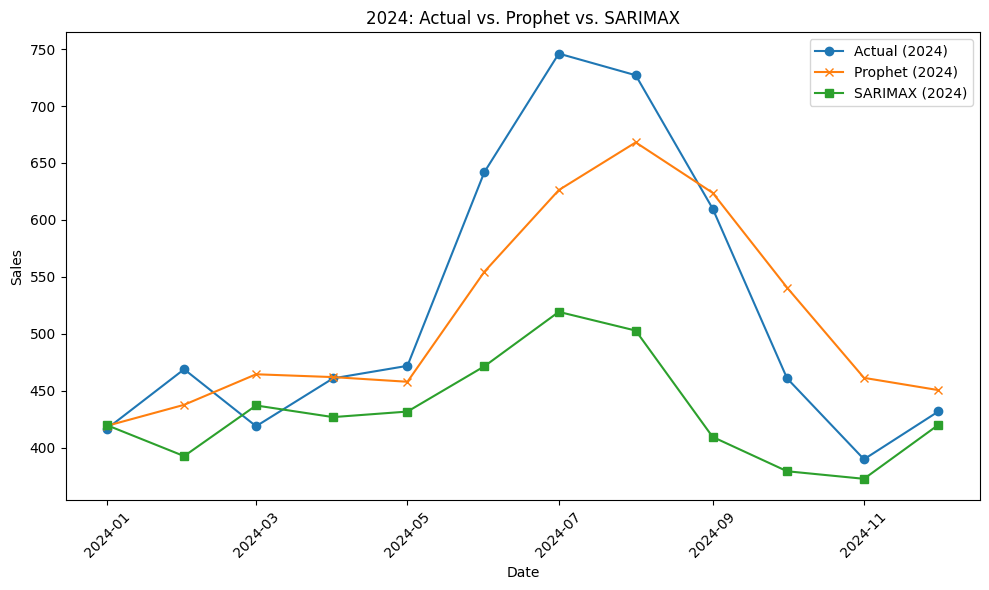


=== 2025 FORECAST COMPARISON ===

         Date  Prophet Forecast  SARIMAX Forecast  Rolling Avg (12M)
0  2025-01-01            416.02            434.30             428.33
1  2025-02-01            406.03            408.01             428.33
2  2025-03-01            440.65            452.75             428.33
3  2025-04-01            421.50            442.67             428.33
4  2025-05-01            418.93            447.58             428.33
5  2025-06-01            447.53            487.32             428.33
6  2025-07-01            465.41            535.10             428.33
7  2025-08-01            446.61            518.67             428.33
8  2025-09-01            404.73            425.36             428.33
9  2025-10-01            390.49            395.24             428.33
10 2025-11-01            387.40            388.60             428.33
11 2025-12-01            422.61            436.00             428.33


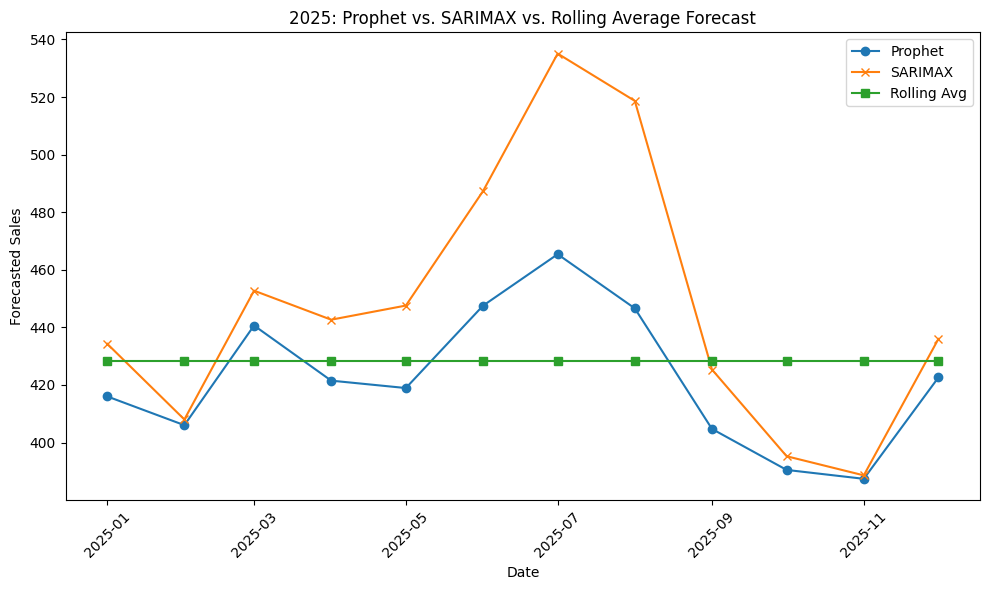


All done!



In [4]:
##############################
#  STEP 0: INSTALL DEPENDENCIES
##############################
# For Google Colab or a fresh environment, uncomment:
# !pip install prophet statsmodels openpyxl xlsxwriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

##############################
#  STEP 1: LOAD THE DATA
##############################
df = pd.read_excel("ts.xlsx", sheet_name="Data")[["time", "TSPN", "Promotion"]]
df.rename(columns={"time": "ds", "TSPN": "y", "Promotion": "promotion"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds').reset_index(drop=True)

print("Data Head:")
print(df.head())
print("\nData Tail:")
print(df.tail())

##############################
#  STEP 2: FEATURE ENGINEERING
##############################
df['month'] = df['ds'].dt.month
df['y_lag1'] = df['y'].shift(1)
df['y_roll3'] = df['y'].rolling(window=3).mean()

# Drop any rows with NaN (from shifting/rolling)
df = df.dropna().reset_index(drop=True)

##############################
#  STEP 3: TRAIN/TEST SPLIT
##############################
# We'll use the last 12 months (all of 2024) as test set
forecast_horizon = 12
train_df = df.iloc[:-forecast_horizon].copy()  # Up to 12/2023
test_df  = df.iloc[-forecast_horizon:].copy()  # 01/2024 to 12/2024

print("\nTrain range: {} to {}".format(train_df['ds'].min(), train_df['ds'].max()))
print("Test range:  {} to {}".format(test_df['ds'].min(), test_df['ds'].max()))

##############################
#  STEP 4: PROPHET MODEL
##############################
model_p = Prophet()
model_p.add_regressor("promotion")
model_p.add_regressor("month")
model_p.add_regressor("y_lag1")
model_p.add_regressor("y_roll3")
model_p.fit(train_df)

# We'll forecast 24 months beyond the last training date
future_periods = 24  # (to cover 2024 + 2025)
future_p = model_p.make_future_dataframe(periods=future_periods, freq='MS')

# Prepare exogenous (promotion, month, y_lag1, y_roll3) for the entire train + future
avg_promotion = train_df['promotion'].mean()

# 1) 'promotion' for the future
future_promo_values = [avg_promotion]*future_periods
future_p['promotion'] = list(train_df['promotion']) + future_promo_values

# 2) 'month' from the ds column
future_p['month'] = future_p['ds'].dt.month

# 3 & 4) Merge in 'y_lag1' and 'y_roll3' from the original df
# For future months that have no actual data, fill with last known.
merged_future = future_p.merge(df[['ds','y_lag1','y_roll3']], on='ds', how='left')
last_lag1  = train_df['y'].iloc[-1]
last_roll3 = train_df['y'].rolling(3).mean().iloc[-1]

merged_future['y_lag1']  = merged_future['y_lag1'].fillna(last_lag1)
merged_future['y_roll3'] = merged_future['y_roll3'].fillna(last_roll3)

# This is your final future df for Prophet
future_p = merged_future.copy()

# Forecast
forecast_p = model_p.predict(future_p)
forecast_p = forecast_p[['ds','yhat']].copy()

##############################
#  STEP 4A: EVALUATE PROPHET ON 2024 TEST
##############################
# Instead of slicing with .loc[start:end], we merge on ds to avoid KeyError
test_df_p = test_df[['ds','y']].copy()
test_df_p = test_df_p.merge(forecast_p, on='ds', how='left')  # merges yhat into test rows
test_df_p.rename(columns={'yhat':'forecast_prophet'}, inplace=True)

# Calculate metrics on 2024
mae_p_2024 = mean_absolute_error(test_df_p['y'], test_df_p['forecast_prophet'])
rmse_p_2024 = np.sqrt(mean_squared_error(test_df_p['y'], test_df_p['forecast_prophet']))
mape_p_2024 = mean_absolute_percentage_error(test_df_p['y'], test_df_p['forecast_prophet'])*100

##############################
#  STEP 5: SARIMAX MODEL
##############################
sarima_order = (1,1,1)
sarima_seasonal_order = (1,1,1,12)

model_s = SARIMAX(
    train_df['y'],
    order=sarima_order,
    seasonal_order=sarima_seasonal_order,
    exog=train_df[['promotion','month','y_lag1','y_roll3']],
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_s = model_s.fit(disp=False)  # might show a convergence warning

##############################
#  STEP 5A: MAKE 24-MONTH EXOG FOR SARIMAX
##############################
future_dates_sarima = pd.date_range(
    start=train_df['ds'].max() + pd.DateOffset(months=1),
    periods=24,
    freq='MS'
)

# We'll assume the same average promotion for the future
future_promotions_24 = np.array([avg_promotion]*24)
future_months_24 = future_dates_sarima.month
last_y = train_df['y'].iloc[-1]
last_y_roll3 = train_df['y'].rolling(window=3).mean().iloc[-1]

future_lag1_24 = np.array([last_y]*24)
future_roll3_24 = np.array([last_y_roll3]*24)

future_exog_24 = pd.DataFrame({
    'promotion': future_promotions_24,
    'month': future_months_24,
    'y_lag1': future_lag1_24,
    'y_roll3': future_roll3_24
}, index=future_dates_sarima)

##############################
#  STEP 5B: FORECAST 24 MONTHS WITH SARIMAX
##############################
forecast_s_24 = results_s.get_forecast(steps=24, exog=future_exog_24)
sarimax_pred_24 = forecast_s_24.predicted_mean

# 1) Ensure the index is set to the DatetimeIndex from future_exog_24
sarimax_pred_24.index = future_exog_24.index  # Now ds is monthly DateTime
sarimax_pred_24.index.name = 'ds'

# 2) Convert that to a DataFrame so we can merge
sarimax_forecast_df = sarimax_pred_24.reset_index()
sarimax_forecast_df.columns = ['ds','yhat_sarimax']


# sarimax_pred_24.index.name = 'ds'
# sarimax_forecast_df = sarimax_pred_24.reset_index()
# sarimax_forecast_df.columns = ['ds','yhat_sarimax']

##############################
#  STEP 5C: EVALUATE SARIMAX ON 2024 TEST
##############################
test_df_s = test_df[['ds','y']].copy()
test_df_s = test_df_s.merge(sarimax_forecast_df, on='ds', how='left')
test_df_s.rename(columns={'yhat_sarimax':'forecast_sarimax'}, inplace=True)

mae_s_2024 = mean_absolute_error(test_df_s['y'], test_df_s['forecast_sarimax'])
rmse_s_2024 = np.sqrt(mean_squared_error(test_df_s['y'], test_df_s['forecast_sarimax']))
mape_s_2024 = mean_absolute_percentage_error(test_df_s['y'], test_df_s['forecast_sarimax'])*100

##############################
#  STEP 6: COMPARE THE 2024 RESULTS
##############################
print("\n=== 2024 TEST RESULTS (ACTUAL vs. FORECAST) ===\n")
metrics_2024 = pd.DataFrame({
    'Model': ['Prophet','SARIMAX'],
    'MAE': [mae_p_2024, mae_s_2024],
    'RMSE': [rmse_p_2024, rmse_s_2024],
    'MAPE(%)': [mape_p_2024, mape_s_2024]
})
metrics_2024[['MAE','RMSE','MAPE(%)']] = metrics_2024[['MAE','RMSE','MAPE(%)']].round(2)
print(metrics_2024)

# Plot: Actual vs. Prophet vs. SARIMAX for 2024
plt.figure(figsize=(10,6))
plt.plot(test_df_p['ds'], test_df_p['y'], marker='o', label='Actual (2024)')
plt.plot(test_df_p['ds'], test_df_p['forecast_prophet'], marker='x', label='Prophet (2024)')
plt.plot(test_df_s['ds'], test_df_s['forecast_sarimax'], marker='s', label='SARIMAX (2024)')
plt.title("2024: Actual vs. Prophet vs. SARIMAX")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##############################
#  STEP 7: 2025 FORECAST COMPARISONS
##############################
# We'll grab the predicted values for 2025 from both models
# Prophet forecast is in forecast_p
# SARIMAX forecast is in sarimax_forecast_df
prophet_2025 = forecast_p[ (forecast_p['ds'] >= "2025-01-01") & (forecast_p['ds'] <= "2025-12-31") ].copy()
sarimax_2025 = sarimax_forecast_df[ (sarimax_forecast_df['ds'] >= "2025-01-01") & (sarimax_forecast_df['ds'] <= "2025-12-31") ].copy()

# We'll also compute a naive 12-month rolling average baseline from the last 12 months of training
rolling_12m_mean = train_df['y'].tail(12).mean()

dates_2025 = pd.date_range("2025-01-01","2025-12-01",freq='MS')
roll_avg_2025 = [rolling_12m_mean]*len(dates_2025)

comparison_2025 = pd.DataFrame({
    'Date': dates_2025,
    'Prophet Forecast': prophet_2025['yhat'].values,
    'SARIMAX Forecast': sarimax_2025['yhat_sarimax'].values,
    'Rolling Avg (12M)': roll_avg_2025
}).round(2)

print("\n=== 2025 FORECAST COMPARISON ===\n")
print(comparison_2025)

# Plot for 2025
plt.figure(figsize=(10,6))
plt.plot(comparison_2025['Date'], comparison_2025['Prophet Forecast'], marker='o', label='Prophet')
plt.plot(comparison_2025['Date'], comparison_2025['SARIMAX Forecast'], marker='x', label='SARIMAX')
plt.plot(comparison_2025['Date'], comparison_2025['Rolling Avg (12M)'], marker='s', label='Rolling Avg')
plt.title("2025: Prophet vs. SARIMAX vs. Rolling Average Forecast")
plt.xlabel("Date")
plt.ylabel("Forecasted Sales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nAll done!\n")
